In [159]:
from dataclasses import dataclass
from enum import Enum
import random


In [219]:

def gen_tree(
        num_leaves: int, 
        min_num_internals : int = 1,  
        max_num_internals : int = None, 
        min_depth : int = 1, 
        max_depth : int = None, 
        min_degree : int = 2, 
        max_degree : int = None,
        min_leaf_depth: int = 0,
    ):
    """
    Generates a random tree with the given number of leafs, minimum depth, maximum depth, maximum and minimum depth (number of children possible per internal (non-leaf) node), and maximum and minimum number of internal nodes.

    If you need exact number of internal nodes, set min_num_internals = max_num_internals = exact number of internal nodes.

    If you need exact depth, set min_depth = max_depth = exact depth.

    If you need exact degree, set min_degree = max_degree = exact degree.
    """

    if max_degree is None:
        max_degree = num_leaves

    if max_num_internals is None:
        max_num_internals = num_leaves - 1

    if max_depth is None:
        max_depth = float("inf")

    depth_info : dict[int, int] = {}
    parent_info : dict[int, int] = {}
    children_info : dict[int, list[int]] = {}
    
    global_id_iterator = 0
    root_id = global_id_iterator
    children_info[root_id] = []
    depth_info[root_id] = 0
    
    leaves : list[list[int]] = [[root_id]] # depth -> list of leaves of that depth

    current_num_leaves = 1
    current_num_internals = 0

    while current_num_leaves < num_leaves:

        shallow_leaves = {d: l for d, l in enumerate(leaves) if len(l) > 0 and d < min_leaf_depth}
        if len(shallow_leaves) > 0:
            chosen_depth = random.choice(list(shallow_leaves.keys()))

            current_num_internals += 1
            
            # Choose a random value for the degree of the parent
            

            min_tba_num_leaves = sum([len(l) * (min_degree ** (min_leaf_depth - d) - 1) for d, l in shallow_leaves.items()])

            x = num_leaves - current_num_leaves - min_tba_num_leaves

            current_num_leaves -= 1

            tba_degree_lower_bound = max(min_degree, (num_leaves - current_num_leaves) - (max_degree - 1) * max(0, max_num_internals - current_num_internals))
            
            tba_degree_upper_bound_1 = min_degree + x // (min_degree ** (min_leaf_depth - chosen_depth - 1))

            tba_degree_upper_bound_2 = (num_leaves - current_num_leaves) - (min_degree - 1) * max(0, min_num_internals - current_num_internals)


            tba_degree_upper_bound = min(max_degree, tba_degree_upper_bound_1, tba_degree_upper_bound_2)

            print(tba_degree_lower_bound, tba_degree_upper_bound, tba_degree_upper_bound_1, tba_degree_upper_bound_2)
            
            if tba_degree_lower_bound > tba_degree_upper_bound:
                raise Exception("No valid tree exists with the given parameters.")
            
            tba_degree = random.randint(tba_degree_lower_bound, tba_degree_upper_bound)

            parent_id_index = random.randint(0, len(shallow_leaves[chosen_depth]) - 1)
            parent_id = shallow_leaves[chosen_depth].pop(parent_id_index)

        elif len(leaves) - 1 < min_depth:
            chosen_depth = len(leaves) - 1
            parent_id_index = random.randint(0, len(leaves[chosen_depth]) - 1)
            parent_id = leaves[chosen_depth].pop(parent_id_index)

            current_num_internals += 1
            current_num_leaves -= 1
            
            # Choose a random value for the degree of the parent
            
            tba_degree_lower_bound = max(min_degree, (num_leaves - current_num_leaves) - (max_degree - 1) * max(0, max_num_internals - current_num_internals))
            
            tba_degree_upper_bound = min(max_degree, (num_leaves - current_num_leaves) - (min_degree - 1) * max(0, min_num_internals - current_num_internals))
            
            tba_degree = random.randint(tba_degree_lower_bound, tba_degree_upper_bound)

        else:
            # Choose a random depth for the parent (the leaf to add children to)
            depths_options = [d for d, v in enumerate(leaves) if len(v) > 0 and d < max_depth]

            if len(depths_options) > 0:
                
                # Choose a random depth for the parent (the leaf to add children to)
                chosen_depth = random.choice(depths_options)
                
                # Choose a random leaf from the current depth
                parent_id_index = random.randint(0, len(leaves[chosen_depth]) - 1)
                parent_id = leaves[chosen_depth].pop(parent_id_index)

                current_num_internals += 1
                current_num_leaves -= 1
                
                # Choose a random value for the degree of the parent
                
                tba_degree_lower_bound = max(min_degree, (num_leaves - current_num_leaves) - (max_degree - 1) * max(0, max_num_internals - current_num_internals))
                
                tba_degree_upper_bound = min(max_degree, (num_leaves - current_num_leaves) - (min_degree - 1) * max(0, min_num_internals - current_num_internals))
                
                tba_degree = random.randint(tba_degree_lower_bound, tba_degree_upper_bound)

            else:
                # Choose a random internal non-full node to add children to.
                non_max_degree_node_options = [_node for _node, _children in children_info.items() if len(_children) < max_degree]
                
                if len(non_max_degree_node_options) == 0:
                    raise Exception("No valid tree exists with the given parameters.")
                    
                # Select a pair of nodes, where the first one is not maximum degree and the second one is not minimum degree, such that the first one is higher (closer to the root) than the second one

                highest_node = min(non_max_degree_node_options, key=lambda _node: depth_info[_node], default=None)

                non_min_degree_node_options = [_node for _node, _children in children_info.items() if len(_children) > min_degree]
                
                deepest_node = max(non_min_degree_node_options, key=lambda _node: depth_info[_node], default=None)

                # If no such pair exists, then the method is not valid. We move to another method: add leafs to existing internal nodes.
                if highest_node is not None and deepest_node is not None and depth_info[highest_node] < depth_info[deepest_node]:
                
                    # Move an edge under the deepest_non_min_degree_node to under the highest_non_max_degree_node
                    
                    # Choose a random child of the deepest_non_min_degree_node
                    child_id = random.choice(children_info[deepest_node])
                    # Remove the child from the children list of the deepest_non_min_degree_node
                    children_info[deepest_node].remove(child_id)
                    # Add the child to the children list of the highest_non_max_degree_node
                    children_info[highest_node].append(child_id)
                    # Update the parent_info
                    parent_info[child_id] = highest_node
                    # Update the depth_info
                    depth_info[child_id] = depth_info[highest_node] + 1
                    # Update depth_info of all descendants of the child, using BFS
                    queue = [child_id]
                    while len(queue) > 0:
                        current_node = queue.pop(0)
                        old_depth = depth_info[current_node]
                        new_depth = depth_info[parent_info[current_node]] + 1
                        if current_node not in children_info:
                            # Update leaves
                            leaves[old_depth].remove(current_node)
                            leaves[new_depth].append(current_node)
                        depth_info[current_node] = new_depth
                        queue += children_info[current_node]
                    continue
                
                # else:
                
                # Add leafs to existing internal nodes.

                parent_id = random.choice(non_max_degree_node_options)

                # Get the depth of the parent
                chosen_depth = depth_info[parent_id]

                # Choose a random value for the to-be-added degree of the parent

                tba_degree_lower_bound = max(1, (num_leaves - current_num_leaves) - (max_degree - 1) * max(0, max_num_internals - current_num_internals))
                
                tba_degree_upper_bound = min(
                    max_degree - len(children_info[parent_id]),
                    (num_leaves - current_num_leaves) - (min_degree - 1) * max(0, min_num_internals - current_num_internals)
                )

                if tba_degree_lower_bound > tba_degree_upper_bound:
                    raise Exception("No valid tree exists with the given parameters.")
                
                tba_degree = random.randint(tba_degree_lower_bound, tba_degree_upper_bound)
            
        if parent_id not in children_info:
            children_info[parent_id] = []
        
        if chosen_depth + 1 >= len(leaves):
            leaves.append([])

        for _ in range(tba_degree):
            global_id_iterator += 1
            leaves[chosen_depth + 1].append(global_id_iterator)
            parent_info[global_id_iterator] = parent_id
            depth_info[global_id_iterator] = chosen_depth + 1
            children_info[parent_id].append(global_id_iterator)
            current_num_leaves += 1

    return depth_info, parent_info, children_info, leaves



In [245]:
depth_info, parent_info, children_info, leaves = gen_tree(100, min_leaf_depth=7)
# children_info.sort(key=lambda x: depth_info[x[0]])
# sort key of dict
sorted(children_info.items(), key=lambda x: x[0])

2 1 1 100


TypeError: cannot unpack non-iterable NoneType object

In [ ]:

def gen_conventional_node_ids(leaf_nodes : list[int], children_info : dict[int, list[int]], root_node_id : int = 0):
    """
    Generate new node ids, based on this convention:
    - leaf nodes are numbered first, from 0 to len(leaf_nodes) - 1 (inclusive)
    - then, a dummy node is added. Its id is len(leaf_nodes).
    - then non-leaf nodes, from len(leaf_nodes) + 1 to len(leaf_nodes) + len(children_info) - 1 (inclusive)
    - then finally, the root node
    """
    middle_nodes = [node_id for node_id in children_info.keys() if node_id != root_node_id and len(children_info[node_id]) > 0]
    random.shuffle(middle_nodes)
    random.shuffle(leaf_nodes)
    # old_dummy_node_id = -1 # stub
    node_ids_sorted = leaf_nodes + [-1] + middle_nodes + [root_node_id]
    new_node_ids_map = { old_node_id : new_node_id for new_node_id, old_node_id in enumerate(node_ids_sorted) }
    new_root_node_id = len(node_ids_sorted) - 1
    new_leaf_nodes = list(range(len(leaf_nodes)))
    return new_node_ids_map, new_leaf_nodes, new_root_node_id



In [ ]:
from matplotlib import pyplot as plt

In [227]:
import numpy as np

In [242]:
n = 20
arr = [random.randint(1, n) for _ in range(n*10)]
arrnp = [np.random.randint(1, n+1) for _ in range(n*10)]

(array([13.,  8., 15.,  9., 15.,  9., 10., 10.,  5., 12., 12., 10.,  6.,
         9.,  9., 17.,  6.,  6.,  9., 10.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

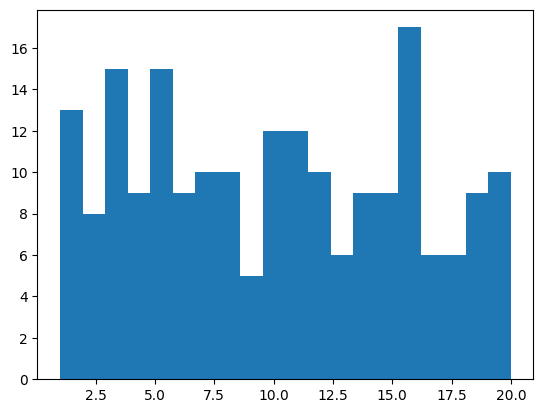

In [243]:
plt.hist(arr, bins=n)

(array([10.,  8., 10., 10.,  8., 12., 14.,  9.,  9.,  6.,  8., 11.,  8.,
        10., 12., 11., 16.,  9., 12.,  7.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <BarContainer object of 20 artists>)

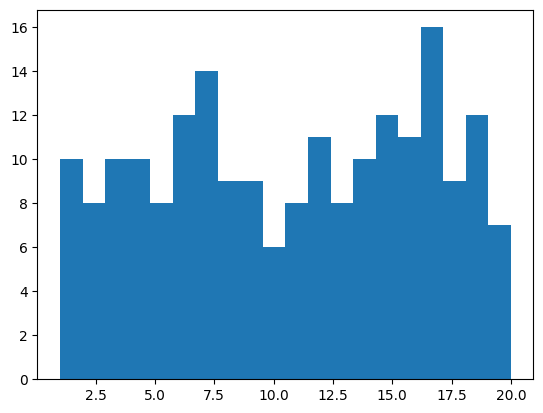

In [244]:
plt.hist(arrnp, bins=n)

In [ ]:

def reevaluate_tree(depth_info : dict[int, int], parent_info : dict[int, int], children_info : dict[int, int], new_node_ids_map : dict[int, int]):
    """
    Reevaluate tree information based on the new node_id mapping.
    """
    new_parent_info = {}
    new_children_info = {}
    new_depth_info = {}
    for old_node_id, new_node_id in new_node_ids_map.items():
        if old_node_id in parent_info:
            new_parent_info[new_node_id] = new_node_ids_map[parent_info[old_node_id]]
        if old_node_id in children_info:
            new_children_info[new_node_id] = [new_node_ids_map[child_id] for child_id in children_info[old_node_id]]
        if old_node_id in depth_info:
            new_depth_info[new_node_id] = depth_info[old_node_id]
    return new_depth_info, new_parent_info, new_children_info



In [ ]:


class NodeType(Enum):
    AND = "AND"
    OR = "OR"
    LEAF = "LEAF"
    DUMMY = "DUMMY"

def reverse_node_type(node_type):
    if node_type == NodeType.AND:
        return NodeType.OR
    elif node_type == NodeType.OR:
        return NodeType.AND
    else:
        return node_type



def assign_node_type(depth_info: dict[int, int], leaf_nodes : list[int], children_info: dict[int, int], root_node_id : int, strict_and_or: bool = True, root_node_type : NodeType = None):
    """
    Randomly assigns a node type to each node in the tree, where the node type is either "AND", "OR", or "LEAF".
    """
    node_type_info = {}
    if root_node_type is None:
        root_node_type = random.choice([NodeType.AND, NodeType.OR])
    reversed_root_node_type = reverse_node_type(root_node_type)
    node_type_info[root_node_id] = root_node_type
    for node_id in leaf_nodes:
        node_type_info[node_id] = NodeType.LEAF
    for node_id, node_children_ids in children_info.items():
        if node_children_ids is None or len(node_children_ids) == 0:
            node_type_info[node_id] = NodeType.LEAF
            continue

        if node_id == root_node_id:
            continue
        
        if strict_and_or:
            node_depth = depth_info[node_id]
            node_type_info[node_id] = root_node_type if node_depth % 2 == 0 else reversed_root_node_type
        else:
            node_type_info[node_id] = random.choice([NodeType.AND, NodeType.OR])

    return node_type_info


In [ ]:


@dataclass
class Node:
    node_id: int
    node_type: NodeType = None
    parent_id: int = None
    depth: int = None
    children_ids: list[int] = None


def get_tree_info(tree_info_size : int, depth_info : dict[int, int], parent_info : dict[int, int], children_info : dict[int, list[int]], node_type_info : dict[int, NodeType]):
    return [Node(
        node_id=node_id,
        node_type=NodeType(node_type_info[node_id]) if node_id in node_type_info else None,
        parent_id=parent_info[node_id] if node_id in parent_info else None,
        children_ids=children_info[node_id] if node_id in children_info else None,
        depth=depth_info[node_id] if node_id in depth_info else None,
    ) for node_id in range(tree_info_size)]



In [ ]:

def gen_tree_info(
        num_leaves: int, 
        min_num_internals : int = 1,  
        max_num_internals : int = None, 
        min_depth : int = 1, 
        max_depth : int = None, 
        min_degree : int = 2, 
        max_degree : int = None
    ):

    depth_info, parent_info, children_info, leaves = gen_tree(
        num_leaves=num_leaves,
        min_num_internals=min_num_internals,
        max_num_internals=max_num_internals,
        min_depth=min_depth,
        max_depth=max_depth,
        min_degree=min_degree,
        max_degree=max_degree
    )

    if depth_info is None:
        return None
    
    leaf_nodes = sum(leaves, [])
    
    new_node_ids_map, new_leaf_nodes, new_root_node_id = gen_conventional_node_ids(leaf_nodes=leaf_nodes, children_info=children_info, root_node_id=0)

    new_depth_info, new_parent_info, new_children_info = reevaluate_tree(depth_info=depth_info, parent_info=parent_info, children_info=children_info, new_node_ids_map=new_node_ids_map)

    node_type_info = assign_node_type(depth_info=new_depth_info, leaf_nodes=new_leaf_nodes, children_info=new_children_info, root_node_id=new_root_node_id)

    tree_info = get_tree_info(
        tree_info_size=len(new_node_ids_map),
        depth_info=new_depth_info,
        parent_info=new_parent_info,
        children_info=new_children_info,
        node_type_info=node_type_info
    )

    return tree_info